In [8]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import time

In [9]:
# Import PySSC module
import PySSC

In [11]:
# Redshift bins
zstakes = np.linspace(0.2,1.5,num=14)
zmin = np.min(zstakes) ; zmax = np.max(zstakes)
# Window function
nz       = 500
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
nbins_T   = len(zstakes)-1
windows_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            windows_T[i,iz] = 1/Dz

## Comparison of Sij matrix for full sky and partial sky Sij for full-sky mask

Using mask map, given as a fits file
lmax = 102
f_sky = 1.0000
3.693968000000001 272.274838


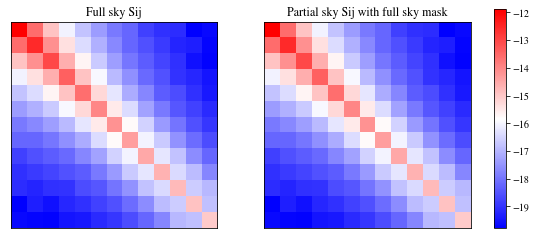

In [13]:
# full sky Sij
t0 = time.clock()
print('Full sky Sij')
Sijw_full = PySSC.Sij(z_arr,windows_T)
# partial sky Sij with full-sky mask
t1 = time.clock()
print('Partial sky Sij')
Sijw_part = PySSC.Sij_psky(z_arr,windows_T,clmask=None,mask='./masks/full_sky_map.fits') #long computation
t2 = time.clock()
print(t1-t0,t2-t0)

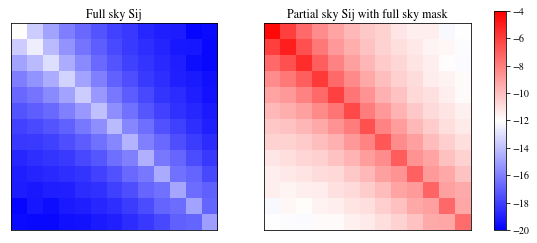

In [38]:
# Plotting the two matrices
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,3.5))
im = axes[0].imshow(np.log(abs(Sijw_full)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-4)
im2 = axes[1].imshow(np.log(abs(Sijw_part)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-4)
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sij')
axes[1].set_title('Partial sky Sij with full sky mask')
fig.subplots_adjust(left=0.02,bottom=0.08,top=0.9,wspace=0.002)
cbar_ax = fig.add_axes([0.9, 0.08, 0.02, 0.87])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)

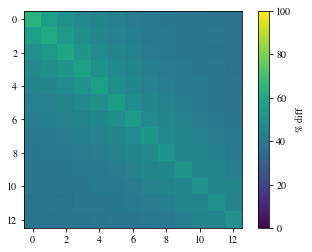

In [39]:
# plt.figure()
# plt.hist2d(np.log(abs(Sijw_full)).flatten(),np.log(abs(Sijw_part)).flatten(),bins=100,density=True)
# plt.xlim(zmin,zmax)
# plt.ylim(zmin,zmax)
# plt.xlabel(r'Full sky $S_{ij}$')
# plt.ylabel(r'Partial sky $S_{ij}$')
# plt.colorbar()

diff = (np.log(abs(Sijw_full)) - np.log(abs(Sijw_part)))/np.log(abs(Sijw_full)) *100
im = plt.imshow(diff)
im.set_clim(vmin=0,vmax=100)
cbar = plt.colorbar(im)
cbar.set_label('% diff')
# print('%.1f%% of the part sky Sij bins are within 5%% of the Sij full sky value' %(np.sum(diff<=5.)/nbins_T**2 *100))

## Partial sky Sij for DES mask

In [31]:
t0 = time.clock()
Sijw_part_DES = PySSC.Sij_psky(z_arr,windows_T,mask='./masks/DES-mask-simple-ring-1024.fits')
t1 = time.clock()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using mask map, given as a fits file
lmax = 102
f_sky = 0.1207
Computed in 4.5 minutes


Text(0.5, 1.0, 'Sij for DES mask')

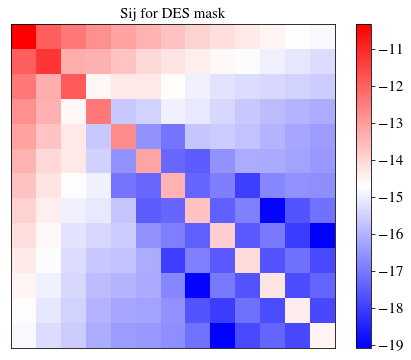

In [48]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(np.log(abs(Sijw_part_DES)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin]) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for DES mask',fontsize=15)

## Partial sky Sij for Euclid mask

In [33]:
t0 = time.clock()
Sijw_part_Euclid = PySSC.Sij_psky(z_arr,windows_T,mask='./masks/Euclid_map_WIDE_SURVEY.fits')
t1 = time.clock()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using mask map, given as a fits file
lmax = 12
f_sky = 0.3762
Computed in 0.3


Text(0.5, 1.0, 'Sij for Euclid mask')

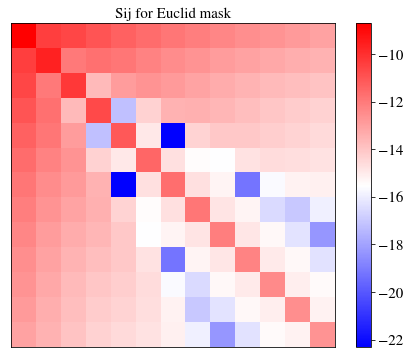

In [47]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(np.log(abs(Sijw_part_Euclid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin]) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for Euclid mask',fontsize=15)

## Partial sky Sij for 6 degrees patch

In [41]:
t0 = time.clock()
Sijw_part_6d = PySSC.Sij_psky(z_arr,windows_T,mask='./masks/circular-mask_5deg.fits')
t1 = time.clock()
print('Computed in %.1f minutes' %((t1-t0)/60))

Using mask map, given as a fits file
lmax = 102
f_sky = 0.0019
Computed in 5.7


Text(0.5, 1.0, 'Sij for 6 deg patch of the sky')

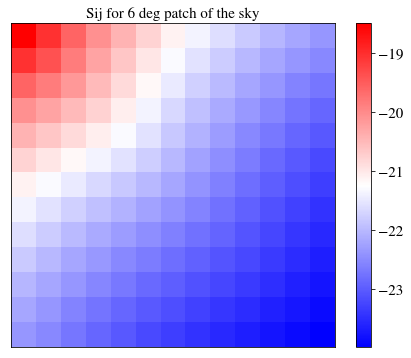

In [46]:
#Plotting
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(np.log(abs(Sijw_part_6d)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin]) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
ax.set_title('Sij for 6 deg patch of the sky',fontsize=15)